# Data Pipelines with TensorFlow

**Objectives**
- How to make pipelines with Deep Learning
- How to load heavy data batch per batch

# Part I: How to make pipelines with Deep Learning

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf

## Load data

Let's load the **PetFinder** dataset. Each row describes a pet, and each column describes an attribute.  
You will use this information to **predict if the pet will be adopted**. 

<details>
    <summary>Below is a description of this dataset.
</summary>

Column | Description| Feature Type | Data Type
------------|--------------------|----------------------|-----------------
Type | Type of animal (Dog, Cat) | Categorical | string
Age |  Age of the pet | Numerical | integer
Breed1 | Primary breed of the pet | Categorical | string
Color1 | Color 1 of pet | Categorical | string
Color2 | Color 2 of pet | Categorical | string
MaturitySize | Size at maturity | Categorical | string
FurLength | Fur length | Categorical | string
Vaccinated | Pet has been vaccinated | Categorical | string
Sterilized | Pet has been sterilized | Categorical | string
Health | Health Condition | Categorical | string
Fee | Adoption Fee | Numerical | integer
Description | Profile write-up for this pet | Text | string
PhotoAmt | Total uploaded photos for this pet | Numerical | integer
AdoptionSpeed | Speed of adoption | Classification | integer
</details>

In [0]:
dataframe = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/petfinder.csv")
dataframe

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,1
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,1
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,0


In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


In [0]:
X_train = train.drop(columns='target')
y_train = train['target']

X_val = val.drop(columns='target')
y_val = val['target']

X_test = test.drop(columns='target')
y_test = test['target']

☝️ Our dataset comprises of both Numerical and Categorical values. We need to preprocess them before feeding into a Neural Network.

You have three options:

**A**. Use sklean to preprocess data before feeding a neural network (no pipelines)  
**B**. Wrap your neural network into a sklearn estimator (pipelines)  
**C**. Use full Tensorflow pipelines  

## A. Use sklean to preprocess data before feeding a neural network (no pipelines)

#### Preprocessing
❓ Create a `X_train_preproc`, `X_val_preproc`, `X_test_preproc` scaling numerical data and One Hot Encoding categorical one

In [0]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector

In [0]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), make_column_selector(dtype_include=["object"]))
)

In [0]:
preproc.fit_transform(X_train).shape

(7383, 186)

In [0]:
X_train_preproc = preproc.fit_transform(X_train)
X_val_preproc = preproc.transform(X_val)
X_test_preproc = preproc.transform(X_test)

#### Neural Network

❓ Fit a Neural Network and evaluate its performance on the test set 

In [0]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
model = Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(X_train_preproc.shape[-1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                5984      
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 15)                495       
_________________________________________________________________
dropout_41 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 16        
Total params: 6,495
Trainable params: 6,495
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=5,
                   verbose=0,
                   restore_best_weights=True)

model.fit(X_train_preproc,
          y_train,
          validation_data=(X_val_preproc, y_val),
          batch_size=64,
          epochs=500,
          callbacks=[es], verbose=0)

In [0]:
model.evaluate(X_test_preproc, y_test)

73/73 [==============================] - 0s 536us/step - loss: 0.5548 - accuracy: 0.7335


[0.5547655820846558, 0.7335355281829834]

## B. Wrap your neural network into a sklearn estimator & pipelines

We can actually treat a Keras model as a scikit-learn estimator, using [Keras Wrappers](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn)  
It allows us to place the estimator inside a sklearn pipeline and include preprocessing inside. We can even gridsearch hyper-params.

❓Run the cells below to undersand the syntax

In [0]:
def create_model():
    
    # Define architecture without input shape yet, as we don't know the shape post preprocessing
    model = Sequential()
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, 
                        epochs=10, 
                        batch_size=32, 
                        verbose=0)

❓ Evaluate - or rather cross-validate - your estimator on your training set already preprocessed

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
cross_val_score(model, X_train_preproc, y_train, cv=3, n_jobs=-1)

array([0.75538397, 0.74563187, 0.75010157])

❓ Wrap your model inside a pipeline including preprocessing and evaluate it directly on the raw data this time

In [0]:
from sklearn.pipeline import make_pipeline

In [0]:
pipe = make_pipeline(preproc, model)
cross_val_score(pipe, X_train, y_train, cv=3)

#### GridSearch CV on the pipeline!

Now that our model is pipelined, we can even grid_searched its hyper-parameters

❓ Run the cells below to understand how the syntax works

In [0]:
def create_model_grid(activation = 'relu', 
                      optimizer='rmsprop'):
    # create model
    model = Sequential()
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(15, activation=activation))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

In [0]:
model_grid = KerasClassifier(
    build_fn=create_model_grid,
    epochs=10,
    batch_size=32,
    verbose=0,
)

In [0]:
pipe_grid = make_pipeline(preproc, model_grid)
#pipe_grid.get_params()

In [0]:
# Now, we can gridsearch the hyper-params of everything
# From the preprocessing, the architecture, the compiler, and the fit!

from sklearn.model_selection import GridSearchCV

param_grid = dict(
    columntransformer__standardscaler__with_mean=[True, False], # Preprocessing hyperparams
    kerasclassifier__activation=['tanh', 'relu'], # Architecture hyperparams
    kerasclassifier__optimizer=["adam", "rmsprop"], # Compiler hyperparams
    kerasclassifier__batch_size=[8, 64], # Fit hyperparams
)

grid = GridSearchCV(estimator=pipe_grid,
                    param_grid=param_grid,
                    cv=2,
                    verbose=2,
                    n_jobs=-1)

In [0]:
grid.fit(X_train, y_train);

In [0]:
grid.best_params_

{'columntransformer__standardscaler__with_mean': True,
 'kerasclassifier__activation': 'relu',
 'kerasclassifier__batch_size': 8,
 'kerasclassifier__optimizer': 'adam'}

In [0]:
grid.best_score_

0.758768618106842

In [0]:
cross_val_score(grid.best_estimator_, X_train, y_train)

array([0.75626272, 0.77251184, 0.77115774, 0.75      , 0.75542003])

## Option C: Full pipeline in Tensorflow

This option is recommended for real projects, especially when you need (i) performance or (ii) production-readiness


<details>
    <summary>Why?</summary>

Indeed, having all preprocessing inside one single TensorFlow Keras model allows to generate one [`tf.Graph`](https://www.tensorflow.org/guide/intro_to_graphs) representation of your model, which is mandatory for distributed computation and serving on many devices (using Tensorflow Lite for back-end-free predictions for instance). 
</details>

The idea is to use **Normalization** and **CategoryEncoding** layers within your model architecture.

### 😌 If the preproc pipeline is sequential, everything is easy

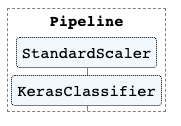

For instance, if there were only numerical data on our dataset:

In [0]:
# Imagine we only have numerical data to scale
X_train_num = X_train.select_dtypes(exclude=['object']).values
X_val_num = X_val.select_dtypes(exclude=['object']).values
X_test_num = X_test.select_dtypes(exclude=['object']).values

In [0]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization

normalizer = Normalization() # Instantiate a "normalizer" layer
normalizer.adapt(X_train_num) # "Fit" it on the train set

model = Sequential()
model.add(normalizer) # Use it as first sequential step
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3a))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train_num,
          y_train,
          validation_data=(X_val_num, y_val),
          batch_size=64,
          epochs=20, verbose=0)

model.evaluate(X_test_num, y_test)

73/73 [==============================] - 0s 550us/step - loss: 0.5400 - accuracy: 0.7335


[0.5399536490440369, 0.7335355281829834]

### 🤯 if the preproc pipeline requires parallel column transformers, TF Sequential API `model.add(...)` is not enough 

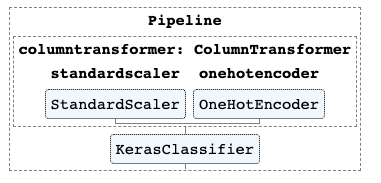

☝️ You will need to use TF **Fonctional API** to produce a non-sequential Neural Network

Don't worry: you **will** be able to learn how to build such models if you want.

📚 [Google's Tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) show you how to solve this exact PetFinder dataset with this method

Non-sequential models look something like:

```python
# Numerical preprocessing model = function(X_numerical)
model_numerical = ...  

# Categorical preprocessing model = function(X_categorical)
model_categorical = ...

# Combined model
all_features = layers.concatenate([model_numerical, model_categorical])

# Then create the Dense network on the preprocessed features
x = tf.keras.layers.Dense(8, activation="relu")(all_features)
x = tf.keras.layers.Dense(2, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

model.compile(...)
```

<img src='https://github.com/lewagon/data-images/blob/master/DL/non_sequential_models.png?raw=true' width=400>

---

# Part II. How to deal with heavy datasets?

⚠️ Most Deep Learning project uses data **too heavy to be loaded on RAM entirely**  
  Fortunately, we only have to train our network **batch per batch**!

✅ Tensorflow provides a powerful [`tf.data.Dataset`]() class that help to deal with it data loading and processing batch-per-batch

✅ Keras provides cool [`tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) wrappers around this to avoid getting your hand too dirty:
- `image_dataset_from_directory`
- `text_dataset_from_directory`
- `timeseries_dataset_from_array`

Let's illustrate this with a heavy images datasets

### 1. Save large files on a hard drive (local or cloud)

❓ Run following cells (never mind the syntax)

In [0]:
! pip install -U --quiet tensorflow-datasets Pillow

In [0]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

In [0]:
# We download 229Mo of images

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 5s 0us/step


In [0]:
# We just unzipped and saved all these file in the following folder 
data_dir

PosixPath('/Users/brunolajoie/.keras/datasets/flower_photos')

In [0]:
# Notice how each photo is saved in a different folder depending on its category
! ls $data_dir

LICENSE.txt daisy       dandelion   roses       sunflowers  tulips


In [0]:
# In total we have 229Mo of files, compressed.
# Imagine they were 50Go ? They couldn't fit in RAM
! du -h $data_dir

 39M	/Users/brunolajoie/.keras/datasets/flower_photos/roses
 54M	/Users/brunolajoie/.keras/datasets/flower_photos/sunflowers
 34M	/Users/brunolajoie/.keras/datasets/flower_photos/daisy
 48M	/Users/brunolajoie/.keras/datasets/flower_photos/dandelion
 54M	/Users/brunolajoie/.keras/datasets/flower_photos/tulips
229M	/Users/brunolajoie/.keras/datasets/flower_photos


In [0]:
# We have 3670 jpg images in 5 classes
len(list(data_dir.glob('*/*.jpg')))

3670

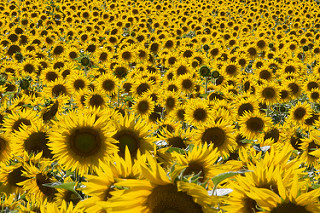

In [0]:
# Just look at one image
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

### 2. Prepare to load images in RAM memory batch per batch 

We will use `image_dataset_from_directory`

In [0]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [0]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  batch_size=32)

Found 3670 files belonging to 5 classes.


☝️ Notice how it automatically labels data into the 5 class!
- By default, `labels='inferred'` from the folder structure
- You can pass a list of labels manually with a list integer

In [0]:
# `ds` is a `tf.data.Dataset` object of "tuples"
ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [0]:
# Dataset contain no real data until they are iterated over 
import sys
sys.getsizeof(ds)

48

In [0]:
for (X_batch, y_batch)  in ds:
    print(X_batch.shape)
    print(y_batch.shape)
    
    break # just show the first element

(32, 256, 256, 3)
(32,)


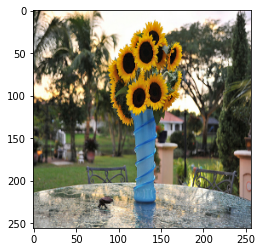

In [0]:
# check first image
plt.imshow(X_batch[0]/255);

`tf.data.Dataset` are just an abstraction that represents a sequence of elements. They allow to

- Load elements batch-per-batch in memory
- From different formats, storage places, etc...
- Apply preprocessing on the fly (ex: shuffle, resize, and many many more)

📚 [TF Guide on data](https://www.tensorflow.org/guide/data)

### Train a model directly on a `Dataset`

❓ Try to fit a very simple dense NN on `ds` 

- You can directly call `model.fit(ds, epochs=1)`
- Your first layer should use `layers.Flatten` to flatten a (256,256,3) picture in into a (256 * 256 * 3,) vector so acceptable for Dense layers
- You can use `loss='sparse_categorical_crossentropy'`: "sparse_" avoids one-hot-encoding the target with `to_categorical(y)`


In [0]:
X_batch.shape

TensorShape([32, 256, 256, 3])

In [0]:
y_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 4, 0, 1, 1, 0, 3, 4, 4, 3, 4, 3, 4, 2, 4, 2, 4, 2, 0, 1, 1, 1,
       1, 0, 4, 4, 0, 1, 1, 4, 4, 4], dtype=int32)>

In [0]:
# Let's try a dummy model, just to prove that it can fit
model = Sequential()

# flattens the picture first into (256*256*3,) vector so it can pass into a Dense layer
model.add(layers.Flatten(input_shape=(256,256,3))) 
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 196608)            0         
_________________________________________________________________
dense_107 (Dense)            (None, 16)                3145744   
_________________________________________________________________
dense_108 (Dense)            (None, 5)                 85        
Total params: 3,145,829
Trainable params: 3,145,829
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy', # "sparse_" allows to avoid one-hot-encoding the target
  metrics=['accuracy'])

model.fit(ds, epochs=1)

115/115 [==============================] - 14s 110ms/step - loss: 721.4946 - accuracy: 0.2070


💡 Accuracy is no better than random because such Dense model architecture is not fitted to the task

In next session, we will use **convolutional neural networks (CNN)**

### (bonus) Proper solution to the flower problem using CNN & early stopping

In [0]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64), # resize on the fly
    batch_size=32)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64), # resize on the fly
    batch_size=32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [0]:
model = tf.keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1. / 255))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[EarlyStopping(patience=0)]
)

Epoch 1/5
92/92 [==============================] - 13s 139ms/step - loss: 1.5042 - accuracy: 0.2909 - val_loss: 1.1650 - val_accuracy: 0.5409
Epoch 2/5
92/92 [==============================] - 13s 138ms/step - loss: 1.1279 - accuracy: 0.5156 - val_loss: 1.0864 - val_accuracy: 0.5668
Epoch 3/5
92/92 [==============================] - 13s 137ms/step - loss: 0.9958 - accuracy: 0.5948 - val_loss: 0.9871 - val_accuracy: 0.5967
Epoch 4/5
92/92 [==============================] - 13s 138ms/step - loss: 0.9150 - accuracy: 0.6406 - val_loss: 0.9450 - val_accuracy: 0.6144
Epoch 5/5
92/92 [==============================] - 13s 139ms/step - loss: 0.8216 - accuracy: 0.6905 - val_loss: 0.8818 - val_accuracy: 0.6322


🏁 **Congratulation** 🏁